# Experiments to mimic wikipedia-api behavior with elasticsearch

The goal of these experiments is to fine-tune the elasticsearch query in order to get results as close to those provided by the wikipedia-api as possible. To do so, we select a random sample of the manually tagged course descriptions, and use the wikipedia-api as ground truth.

**Disclaimer**: 100% similarity with the wikipedia-api is most likely not achievable in the current setting. It seems like wikipedia uses semantic matching including synonyms (e.g. 'gastronomy' yields results like 'French cuisine', which only includes the term gastronomy once in the page content excluding the references), which is not supported in our current elasticsearch index.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

from concept_detection.interfaces.es import ES
from concept_detection.interfaces.wp import WP
from concept_detection.interfaces.db import DB

from concept_detection.test.courses.compare import *

We load the course descriptions from the database and extract a random sample.

In [3]:
db = DB()
wikified_course_descriptions = db.query_wikified_course_descriptions()

# Set of all keywords manually tagged by students in the course descriptions
keyword_list = list(set([result.keywords for course_id in wikified_course_descriptions for result in wikified_course_descriptions[course_id]]))

random.seed(0)
sampled_keyword_list = random.sample(keyword_list, 100)

We also get a list of the ids of pages present in the database. If a page is returned by the wikipedia-api but is not in the database it should not be taken into account to measure the performance.

In [4]:
db_page_ids = db.query_wikipedia_page_ids()

We instantiate the interfaces to interact with both the elasticsearch client and the wikipedia api.

In [5]:
es = ES()
wp = WP()

## Base comparison

We compare the wikipedia api with the simplest elasticsearch query. The following function automates that.

In [6]:
def compare_wp_es(keyword_list, sizes):
    stats = {size: [] for size in sizes}
    for keywords in keyword_list:
        # Get results from wikipedia-api, filter those in db
        wp_results = wp.search(keywords)
        wp_page_ids = [result.page_id for result in wp_results if result.page_id in db_page_ids]
        
        # Get results from elasticsearch
        es_results = es.search(keywords)
        es_page_ids = [result.page_id for result in es_results]

        for size in sizes:
            stats[size].append(confusion_stats(es_page_ids[:size], wp_page_ids[:size]))

    return stats

We compare the top10, top3 and top1 lists of results.

In [7]:
sizes = [10, 3, 1]

stats = compare_wp_es(sampled_keyword_list, sizes)

/Users/hera/graphai/concept_detection/interfaces/es.py:105: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  return self.es.search(index=self.index, query=query, size=limit)


And average the results over all keywords in the sample.

In [8]:
avgs = {
    size: np.mean([confusion['r'] for confusion in stats[size]])
    for size in stats
}

avgs

{10: 0.3452103174603174, 3: 0.34, 1: 0.43}

Almost half of the times, the top page coincides. Also we correctly get about a third of the top3 wikipedia-api pages in the top3 from elasticsearch. Similar for the top10.

## Title boosting

We now compare the wikipedia-api with elasticsearch queries that boost or penalize the matches in the title. We aim to find a good boost value in order to improve how many pages coincide. The following function automates that.

In [9]:
def compare_wp_es_title_boost(keyword_list, sizes, boosts):    
    stats = {
        size: {boost: [] for boost in boosts}
        for size in sizes
    }
    for keywords in keyword_list:
        # Get results from wikipedia-api, filter those in db
        wp_results = wp.search(keywords)
        wp_page_ids = [result.page_id for result in wp_results if result.page_id in db_page_ids]
        
        # Get results from elasticsearch
        es_page_ids = {boost: [] for boost in boosts}
        for boost in boosts:
            if boost >= 0:
                es_results = es.search_boost_title(keywords, boost=boost)
            else:
                es_results = es.search_penalize_title(keywords, penalty=-boost)
            
            es_page_ids[boost] = [result.page_id for result in es_results]

            for size in sizes:
                stats[size][boost].append(confusion_stats(es_page_ids[boost][:size], wp_page_ids[:size]))

    return stats

We define a grid of boost values and again compare the top10, top3 and top1 results.

In [10]:
boosts = [-5, -2, -1, -0.5, -0.2, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5]

title_boost_stats = compare_wp_es_title_boost(sampled_keyword_list, sizes, boosts)

Again we average over all keywords.

In [23]:
title_boost_avgs = {
    size: {
        boost: np.mean([confusion['r'] for confusion in title_boost_stats[size][boost]])
        for boost in title_boost_stats[size]
    }
    for size in title_boost_stats
}

optimal_boosts = {size: (max(title_boost_avgs[size], key=title_boost_avgs[size].get), max(title_boost_avgs[size].values())) for size in title_boost_avgs}
optimal_boosts

{10: (0.3, 0.40534523809523804), 3: (0.5, 0.3633333333333333), 1: (0.2, 0.44)}

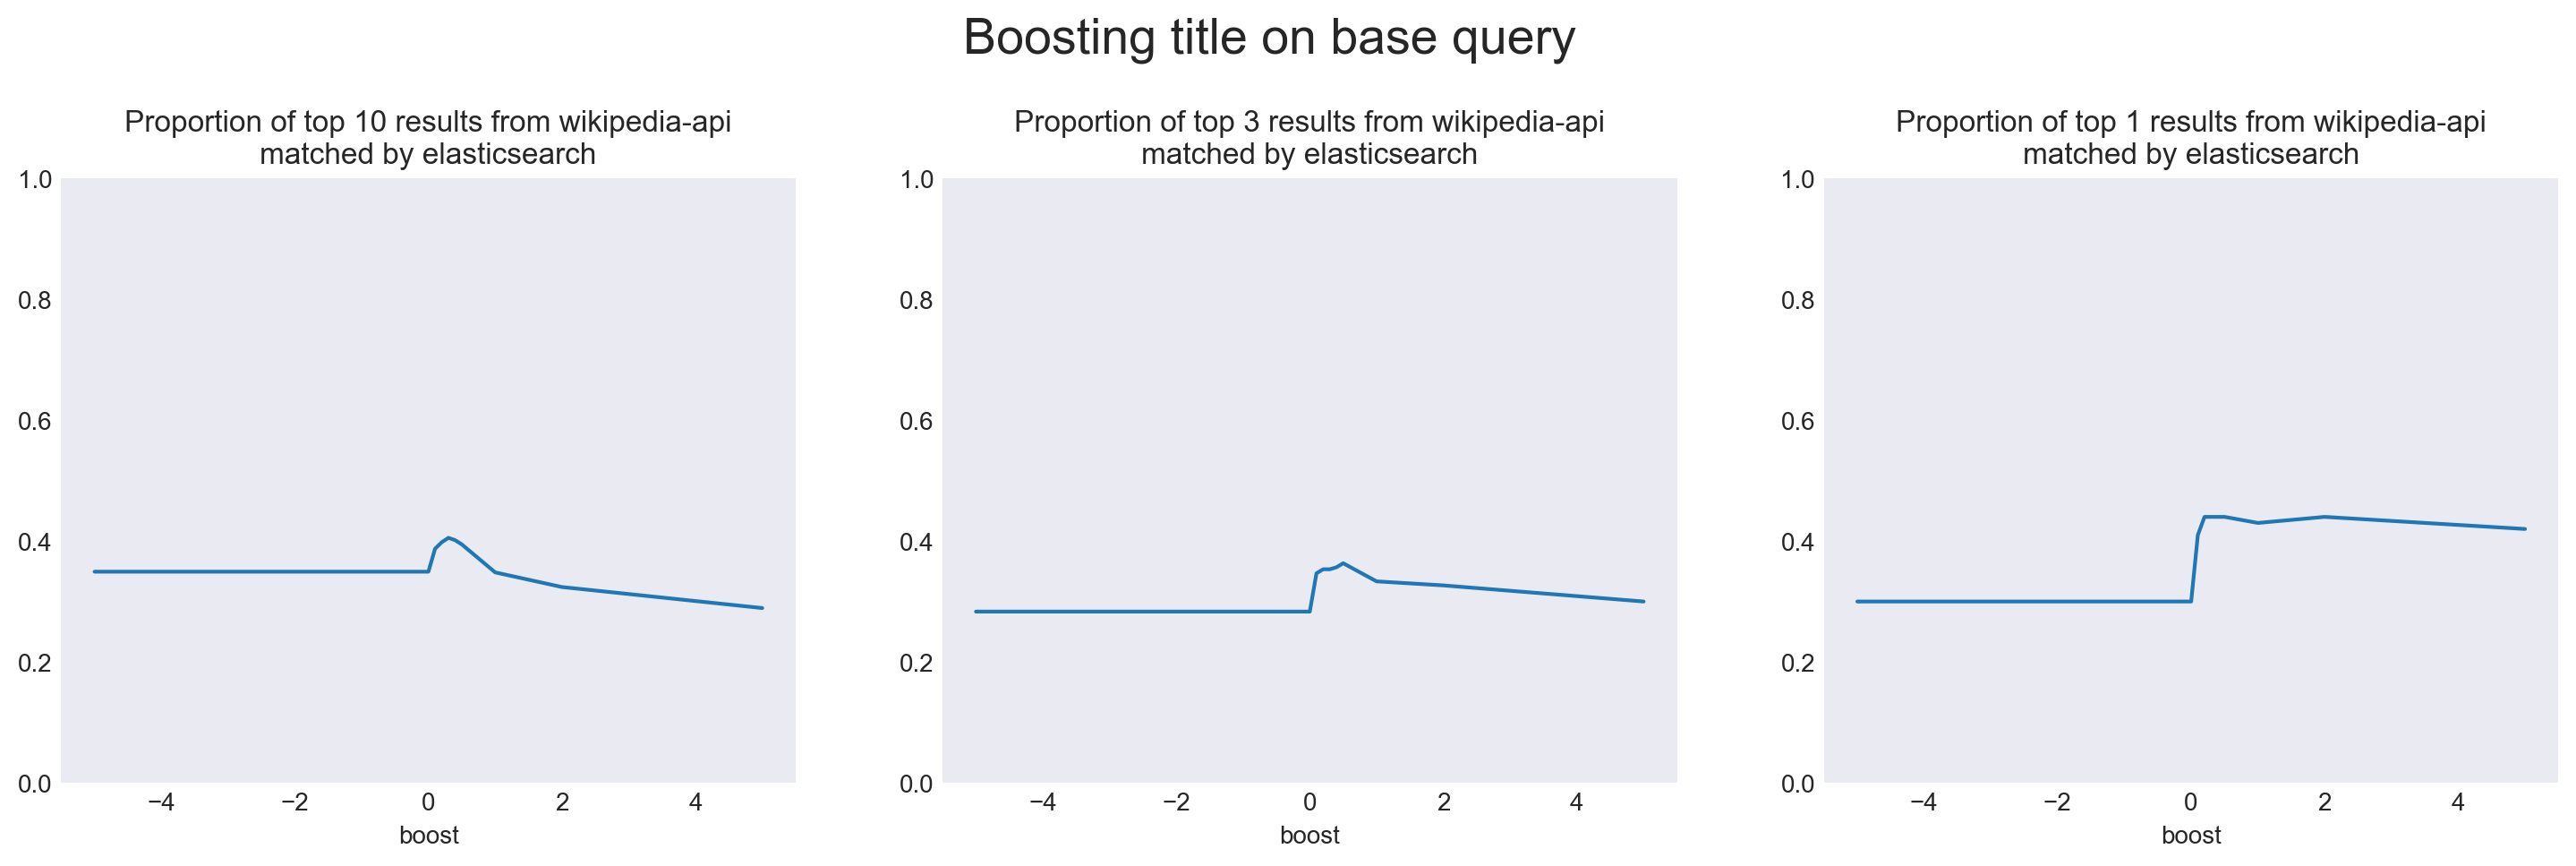

In [41]:
def plot_avgs(avgs, title):
    fig, axs = plt.subplots(1, len(avgs), figsize=(18, 5), dpi=200)
    i = 0
    for size in avgs:
        x = list(avgs[size].keys())
        y = list(avgs[size].values())

        axs[i].plot(x, y)

        axs[i].set_xlabel('boost')
        axs[i].set_ylim([0, 1])
        axs[i].set_title(f'Proportion of top {size} results from wikipedia-api\nmatched by elasticsearch')

        i += 1

    plt.subplots_adjust(top=0.8)
    fig.suptitle(title, size=20)

plot_avgs(title_boost_avgs, 'Boosting title on base query')

The optimal value as boost for title is 0.3. This means that the clause to search in the page title should be given ~1/3 importance with respect to the clause to search in the page content.

## Mediawiki query tweaking

After inspecting the actual elasticsearch query from the wikipedia-api, we try to reproduce as much of it as possible. Notice that our options are very limited, as the most relevant scores that are taken into account in the mediawiki computation involve a `popularity_score` for each page, as well as the number of `incoming_links` and a `ltr naive_additive_decision_tree` model which is not openly available. Furthermore, some fields like `category`, `heading`, `auxiliary_text`, `file_text`, `redirect.title`, `suggest` or `opening_text` are not currently available in the elasticsearch indices, although some could be derived.

In [27]:
def compare_wp_es_mediawiki_title_boost(keyword_list, sizes, boosts):
    stats = {
        size: {boost: [] for boost in boosts}
        for size in sizes
    }
    for keywords in keyword_list:
        # Get results from wikipedia-api, filter those in db
        wp_results = wp.search(keywords)
        wp_page_ids = [result.page_id for result in wp_results if result.page_id in db_page_ids]
        
        # Get results from elasticsearch
        es_page_ids = {boost: [] for boost in boosts}
        for boost in boosts:
            es_results = es.search_mediawiki_simplified(keywords, boost_title=boost)
            es_page_ids[boost] = [result.page_id for result in es_results]

            for size in sizes:
                stats[size][boost].append(confusion_stats(es_page_ids[boost][:size], wp_page_ids[:size]))

    return stats

def compare_wp_es_mediawiki_content_boost(keyword_list, sizes, boosts):
    stats = {
        size: {boost: [] for boost in boosts}
        for size in sizes
    }
    for keywords in keyword_list:
        # Get results from wikipedia-api, filter those in db
        wp_results = wp.search(keywords)
        wp_page_ids = [result.page_id for result in wp_results if result.page_id in db_page_ids]
        
        # Get results from elasticsearch
        es_page_ids = {boost: [] for boost in boosts}
        for boost in boosts:
            es_results = es.search_mediawiki_simplified(keywords, boost_content=boost)
            es_page_ids[boost] = [result.page_id for result in es_results]

            for size in sizes:
                stats[size][boost].append(confusion_stats(es_page_ids[boost][:size], wp_page_ids[:size]))

    return stats

We define a grid of boosts values to use it both with title and content, and compare the top10, top3 and top1 results once more.

In [29]:
mw_boosts = [0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7]

print('Title boosts', end='')
mw_title_boost_stats = compare_wp_es_mediawiki_title_boost(sampled_keyword_list, sizes, mw_boosts)
print('OK')

print('Content boosts', end='')
mw_content_boost_stats = compare_wp_es_mediawiki_content_boost(sampled_keyword_list, sizes, mw_boosts)
print('OK')

Title boostsOK
Content boostsOK


Again we average over all keywords.

In [30]:
mw_title_boost_avgs = {
    size: {
        boost: np.mean([confusion['r'] for confusion in mw_title_boost_stats[size][boost]])
        for boost in mw_title_boost_stats[size]
    }
    for size in mw_title_boost_stats
}

mw_content_boost_avgs = {
    size: {
        boost: np.mean([confusion['r'] for confusion in mw_content_boost_stats[size][boost]])
        for boost in mw_content_boost_stats[size]
    }
    for size in mw_content_boost_stats
}

mw_title_optimal_boosts = {size: (max(mw_title_boost_avgs[size], key=mw_title_boost_avgs[size].get), max(mw_title_boost_avgs[size].values())) for size in mw_title_boost_avgs}
mw_content_optimal_boosts = {size: (max(mw_content_boost_avgs[size], key=mw_content_boost_avgs[size].get), max(mw_content_boost_avgs[size].values())) for size in mw_content_boost_avgs}

print(mw_title_optimal_boosts)
print(mw_content_optimal_boosts)

{10: (0.9, 0.40492460317460316), 3: (0.6, 0.3533333333333333), 1: (0.6, 0.43)}
{10: (1.8, 0.40194047619047607), 3: (1.8, 0.34666666666666657), 1: (2.4, 0.43)}


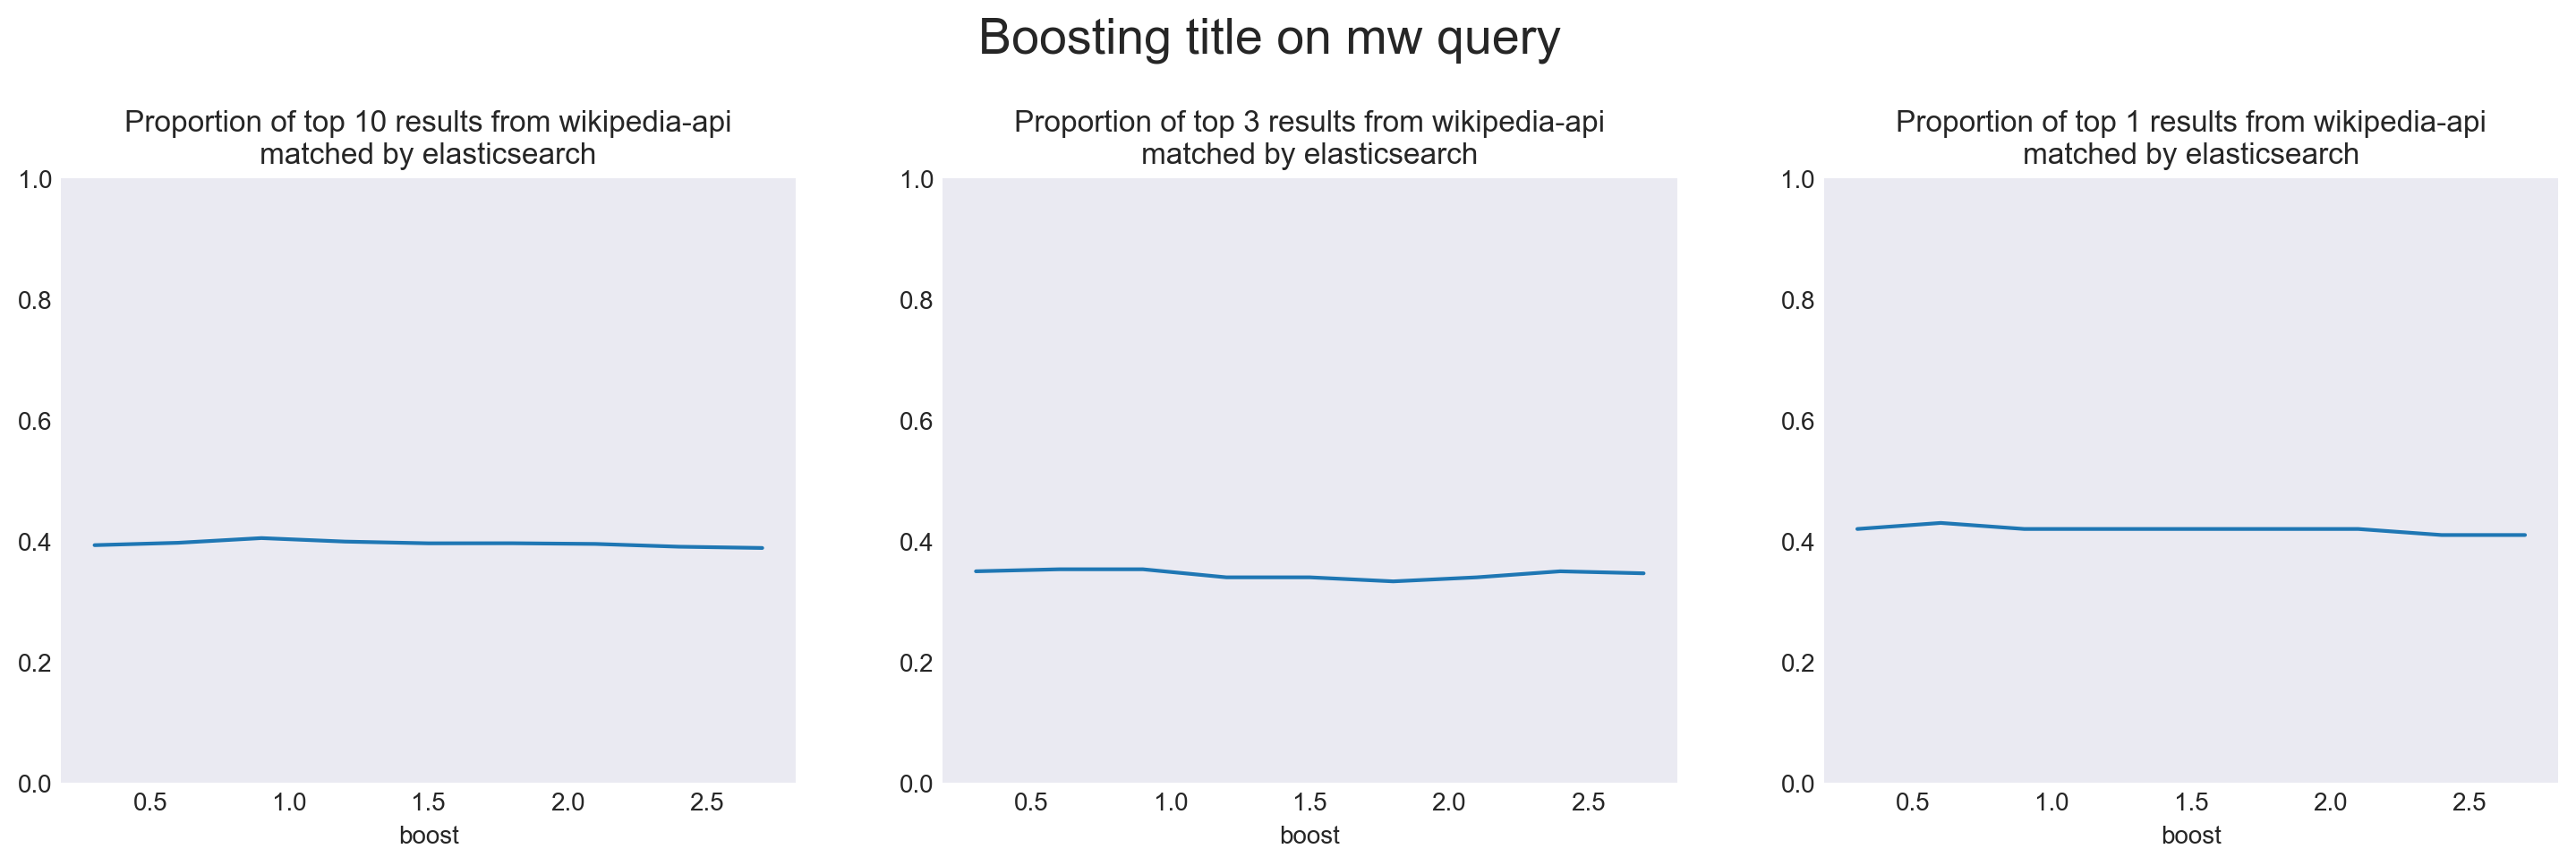

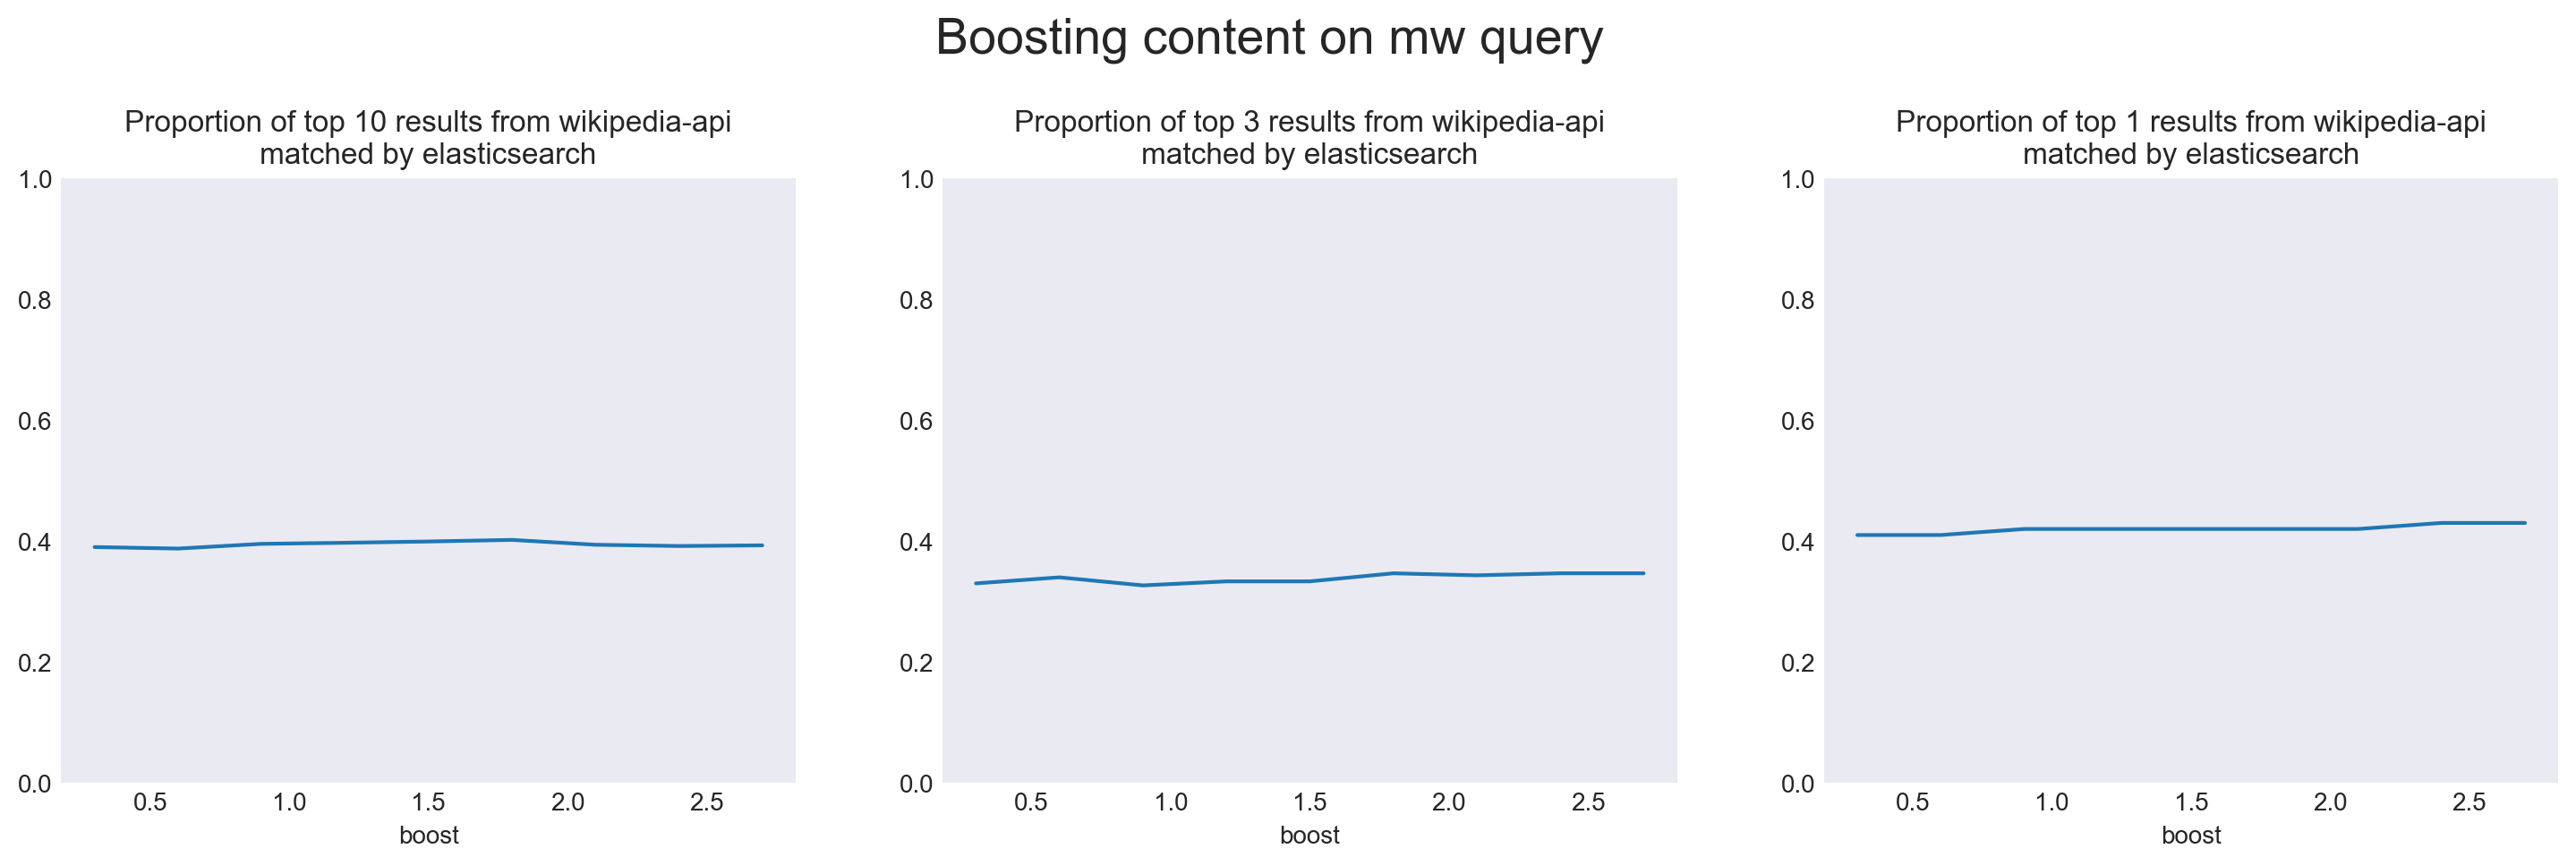

In [42]:
plot_avgs(mw_title_boost_avgs, 'Boosting title on mw query')
plot_avgs(mw_content_boost_avgs, 'Boosting content on mw query')

There does not seem to be much difference in these boosts.